In [2]:
from skopt.benchmarks import branin, hart6
"""The six dimensional Hartmann function defined on the unit hypercube.

It has six local minima and one global minimum f(x*) = -3.32237 at
x* = (0.20169, 0.15001, 0.476874, 0.275332, 0.311652, 0.6573).

More details: <http://www.sfu.ca/~ssurjano/hart6.html>
"""
from sklearn.metrics.scorer import mean_absolute_error as error_func
import skopt
import hyperopt
import numpy as np
import datetime
import time

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator

In [3]:
def log(l, *a, **k):
    if l < 3:
        print(*a, **k)

In [4]:
setting = dict(
    error_level = 0.05,
    benchmark = 'hart6'
)
benchmarks = {
    'branin': {
        'func': branin,
        'space_TPE': [hyperopt.hp.uniform('0', -5.0, 5.0), hyperopt.hp.uniform('1', -5.0, 5.0)],
        'space': [(-5.0, 5.0), (-5.0, 5.0)],
        'x': [np.pi, 2.275],
        'y': 0.397887
    },
    'hart6': {
        'func': hart6,
        'space_TPE': [hyperopt.hp.uniform('%d' % i, -1.0, 1.0) for i in range(6)],
        'space': [(-1.0, 1.0) for i in range(6)],
        'x': [0.20169, 0.15001, 0.476874, 0.275332, 0.311652, 0.6573],
        'y': -3.32237
    }
}

class Target:
    def __init__(self, error_level=1, benchmark='hart6'):
        self.error_level = error_level
        self.records = []
        self.best = None
        self.benchmark = benchmark
    
    def get_space(self, method):
        if method == 'TPE':
            return benchmarks[self.benchmark]['space_TPE']
        else:
            return benchmarks[self.benchmark]['space']
    
    def target(self, x, error_level=None):
        input_time = time.time()
        if error_level is None:
            error_level = self.error_level
        log(4, 'loop', len(self.records))
        log(4, 'new_x', x)
        err_x = error_func(benchmarks[self.benchmark]['x'], x)
        log(4, 'error of x', err_x)
        res_true = benchmarks[self.benchmark]['func'](x)
        res = res_true + np.random.randn() * error_level
        log(4, 'output score', res)
        log(4, 'true score', res_true)
        
        change = False
        if self.best is None:
            self.best = 0
            change = True
        elif res < self.records[self.best]['y_output']:
            self.best = len(self.records)
            change = True
            
        output_time = time.time()
        self.records.append({
            'input_time': input_time,
            'output_time': output_time,
            'idx': len(self.records),
            'x': x, 
            'x_error': err_x,
            'y_true': res_true,
            'y_output': res,
            'best': self.best
        })
        if change:
            log(3, 'New Best:',self.records[-1])
        return res
    
    def final_score(self):
        return self.target(self.x, 0)

In [49]:
def plot_results(*methods, true_minimum=None, max_n_calls=np.inf, choice='x_error', x_mark='n', target_time=0, 
                max_time=1000):
    F = plt.gcf(fig_size=(800, 800))
    ax = plt.gca()
    ax.set_title("Convergence plot")
    if x_mark == 'n':
        ax.set_xlabel("Number of calls $n$")
    else:
        ax.set_xlabel("Time Consumed By Optimizer")
        
    ax.set_ylabel(choice)
    ax.grid()
    colors = cm.viridis(np.linspace(0.25, 1.0, len(methods)))
    for result, color in zip(methods, colors):
#         print(result)
        name = result['name']
        records = result['result'].records
        n_calls = int(np.min([len(records), max_n_calls]))
#         print(n_calls)
        mins = [records[r['best']][choice] for r in records[:n_calls]]
#         mins_e_x = [records[r['best']]['x_error'] for r in records[:n_calls]]
#         print(name, mins)
#         ax.plot(range(1, n_calls + 1), mins_out, c=colors[idx * 2 - 1], marker=".", markersize=12, lw=2, label=name)
        if x_mark == 'n':
            ax.plot(range(1, n_calls + 1), mins, c=color, marker=".", markersize=12, lw=2, label=name)
        else:
            t0 = records[0]['output_time']
            time_consume = []
            for r in records[:n_calls]:
                time_consume.append(r['input_time'] - t0)
                t0 += r['output_time'] - r['input_time'] - target_time
                if time_consume[-1] > max_time:
                    mins = mins[:len()]
                    break
            ax.plot(time_consume, mins, c=color, marker=".", markersize=12, lw=2, label=name)
    if true_minimum is not None:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")

    if true_minimum or name:
        ax.legend(loc="best")
    return ax

In [26]:
import pickle
with open('Compare.pkl', 'wb') as fl:
    pickle.dump({
        'name': 'Compare Result', 
        'Settings': {
            'setting': setting, 
            'benchmarks': benchmarks, 
        },
        'data': methods,
    }, fl)

In [6]:
n_calls = 100

In [7]:
bays = {'name':'BaysionOptimize', 'func': skopt.gp_minimize, 'kwargs': {'n_calls': n_calls}}
t = Target(**setting)
bays['result'] = t
bays['func'](t.target, t.get_space(bays['name']), **bays['kwargs'])

New Best: {'y_output': 0.06708636184327571, 'x_error': 0.50936056778905081, 'idx': 0, 'output_time': 1501568399.0958352, 'best': 0, 'input_time': 1501568399.0954878, 'y_true': -0.00012039431379579958, 'x': [0.35151104237192765, -0.9608314233679609, 0.74818690770663387, 0.75037531488858611, 0.76577935120657048, 0.062282632807374672]}
New Best: {'y_output': -0.024397267492691364, 'x_error': 0.79353022705301246, 'idx': 1, 'output_time': 1501568399.0968328, 'best': 1, 'input_time': 1501568399.0966997, 'y_true': -1.9372570295989424e-06, 'x': [0.028748665569588328, 0.3979697287894326, -0.99080002316436366, 0.9466170670505476, -0.49413065266780865, -0.73823855621550982]}
New Best: {'y_output': -0.054321407541183704, 'x_error': 0.71879172200505825, 'idx': 4, 'output_time': 1501568399.099153, 'best': 4, 'input_time': 1501568399.0989168, 'y_true': -1.0806423720549977e-11, 'x': [0.17661223839536833, 0.25153630629687362, -0.90865999780605544, -0.59334325572690805, -0.2197316002315608, -0.743253410

/home/autumnsun/.local/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/autumnsun/.local/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


New Best: {'y_output': -0.098991126183567729, 'x_error': 0.83503525332511164, 'idx': 20, 'output_time': 1501568404.7863243, 'best': 20, 'input_time': 1501568404.7861903, 'y_true': -3.34308483040447e-17, 'x': [-0.46762489598743706, -1.0, -1.0, 0.33499262396323276, -1.0, 1.0]}
New Best: {'y_output': -0.25960919280374206, 'x_error': 0.52988346751639959, 'idx': 48, 'output_time': 1501568423.7960691, 'best': 48, 'input_time': 1501568423.7958932, 'y_true': -0.30403048575200786, 'x': [0.41728821120210013, 0.97364666543960032, 0.94129793885692536, 0.91897154747921972, 0.99424018942207648, 0.30788574730152507]}
New Best: {'y_output': -0.30543326847619018, 'x_error': 0.56928062749176067, 'idx': 53, 'output_time': 1501568428.5207715, 'best': 53, 'input_time': 1501568428.5206385, 'y_true': -0.25400377651206857, 'x': [0.23838460135932743, 0.97469668965414036, 0.95815042992086918, 0.87267384628015132, -0.81472644790830295, 0.30799425017222704]}
New Best: {'y_output': -0.47121436356854091, 'x_error':

          fun: -3.2856680999672707
    func_vals: array([  6.70863618e-02,  -2.43972675e-02,  -8.87101471e-03,
         3.89486667e-03,  -5.43214075e-02,  -5.57312253e-02,
         7.33415756e-03,  -1.64758492e-02,   3.16884663e-03,
        -1.46245241e-02,  -4.79452425e-02,  -5.80807861e-03,
        -2.49807177e-02,  -1.25381549e-02,  -7.26773653e-02,
        -5.83860116e-02,  -5.45602995e-02,   5.62371219e-02,
        -9.31524273e-03,   3.29585713e-02,  -9.89911262e-02,
        -9.78994152e-03,   1.20861956e-01,   6.43408379e-02,
        -1.36195021e-02,  -2.77873495e-02,   1.93380778e-02,
         2.54336645e-02,   8.31486104e-02,   3.44823116e-02,
        -5.84513568e-02,   1.88277317e-02,  -4.02750919e-02,
         4.02731808e-02,   5.28459712e-02,   2.85721907e-02,
         3.47553599e-02,  -2.57843738e-02,   2.76607019e-02,
         5.91840132e-02,   3.92085525e-02,   8.27618224e-03,
        -8.20241847e-02,  -1.80235630e-02,  -2.99631226e-02,
         1.95724810e-02,  -6.921157

In [8]:
tpe = {'name':'TPE', 'func': hyperopt.fmin, 'kwargs': {'algo':hyperopt.tpe.suggest,'max_evals': n_calls * 10}}
t = Target(**setting)
tpe['result'] = t
tpe['func'](t.target, t.get_space(tpe['name']), **tpe['kwargs'])

New Best: {'y_output': -0.02284193246956712, 'x_error': 0.55861310431071365, 'idx': 0, 'output_time': 1501568482.4889812, 'best': 0, 'input_time': 1501568482.4887855, 'y_true': -0.00010858747333896795, 'x': (0.36815635369711464, -0.9083984385026285, -0.5164856974106045, 0.8423955861890633, 0.4276679723143688, 0.20693542224949812)}
New Best: {'y_output': -0.028772825639714422, 'x_error': 0.56291987082739936, 'idx': 2, 'output_time': 1501568482.4941852, 'best': 2, 'input_time': 1501568482.4940348, 'y_true': -0.078313201447977293, 'x': (0.558436615805856, 0.2646575043373476, -0.8751781678498514, 0.6161137218732382, 0.9361211222176129, 0.0684779071195103)}
New Best: {'y_output': -0.071072826167769193, 'x_error': 0.32231752920488188, 'idx': 3, 'output_time': 1501568482.4967682, 'best': 3, 'input_time': 1501568482.4966223, 'y_true': -0.089221665203037967, 'x': (0.5173395651123593, 0.535571877326162, 0.7872398943026573, 0.8019009505329366, 0.5929712085169165, 0.7717396794382598)}
New Best: {'

{'0': 0.3860995912341514,
 '1': 0.9316173880486532,
 '2': 0.756811745048473,
 '3': 0.6203891251576741,
 '4': 0.60888473832428,
 '5': 0.05662062330052382}

In [9]:
gbrt = {'name':'GradientBoost', 'func': skopt.gbrt_minimize, 'kwargs': {'n_calls': n_calls * 10}}
t = Target(**setting)
gbrt['result'] = t
gbrt['r'] = gbrt['func'](t.target, t.get_space(gbrt['name']), **gbrt['kwargs'])

New Best: {'y_output': -0.015559786810889886, 'x_error': 0.77409373786657654, 'idx': 0, 'output_time': 1501568495.5483763, 'best': 0, 'input_time': 1501568495.5481327, 'y_true': -6.9454916012770774e-11, 'x': [-0.75056461411866637, -0.8881070704220384, -0.066018031199312377, -0.21317523960775464, -0.048791338435338449, -0.60504813341634911]}
New Best: {'y_output': -0.027617582492138901, 'x_error': 0.65385447515307693, 'idx': 4, 'output_time': 1501568495.5505884, 'best': 4, 'input_time': 1501568495.5504622, 'y_true': -1.5167728794555405e-08, 'x': [0.63266568115015676, -0.86274052222955633, 0.10498277687686519, 0.80384400812226797, -0.5414675979613004, -0.06857781833204557]}
New Best: {'y_output': -0.11275332087916459, 'x_error': 0.61884491767428129, 'idx': 5, 'output_time': 1501568495.5512612, 'best': 5, 'input_time': 1501568495.551134, 'y_true': -1.4966550631831659e-06, 'x': [-0.38274607547875328, 0.90649066174641635, 0.039407563132864309, -0.62386370520933032, -0.2959899507412036, 0.22

In [13]:
rand = {'name':'RandomSearch', 'func': skopt.dummy_minimize, 'kwargs': {'n_calls': n_calls * 1000}}
t = Target(**setting)
rand['result'] = t
rand['func'](t.target, t.get_space(rand['name']), **rand['kwargs'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [15]:
dtree = {'name':'DecisionTree', 'func': skopt.forest_minimize, 'kwargs': {'n_calls': n_calls}}
t = Target(**setting)
dtree['result'] = t
dtree['func'](t.target, t.get_space(dtree['name']), **dtree['kwargs'])

          fun: -3.0504233251582193
    func_vals: array([  1.31100656e-02,  -1.13061981e-02,   5.29026057e-02,
         1.96661353e-02,  -7.45652985e-04,  -5.12097609e-02,
        -8.44744002e-02,   9.06790751e-03,  -2.80094303e-02,
        -1.95131503e-02,  -7.55409171e-02,   8.92629942e-03,
         7.34820203e-02,   1.32935841e-01,  -5.78582289e-02,
        -1.52109882e-02,  -6.66737313e-02,   5.24555661e-02,
         5.53785634e-02,  -1.01187794e-02,   1.34920519e-02,
        -8.92808014e-03,   8.43685058e-02,   1.71463466e-02,
        -7.73023212e-02,   2.79614053e-02,   1.47073236e-02,
         5.30962111e-02,   6.59370369e-02,   8.39980658e-02,
         8.65143626e-02,  -9.66108651e-03,  -1.58480781e-02,
        -3.97054392e-02,  -4.50663646e-03,  -8.95362492e-03,
         7.28435162e-02,  -1.42881268e-01,  -7.57851331e-03,
        -1.48379856e+00,   3.72961268e-02,  -5.10334064e-02,
        -1.44549492e+00,   5.13731228e-02,  -3.15336649e-02,
        -1.33516757e-02,  -8.409564

In [16]:
methods = [bays, tpe, gbrt, rand, dtree]

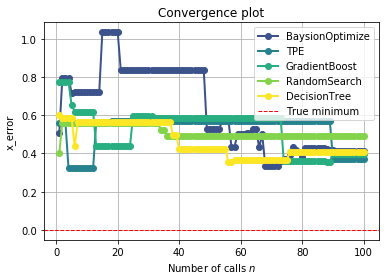

In [17]:
plt.show(plot_results(*methods, true_minimum=0., max_n_calls=100, choice='x_error'))

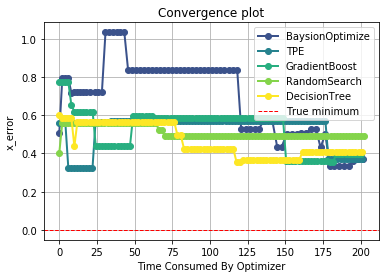

In [38]:
plt.show(plot_results(*methods, true_minimum=0., choice='x_error', x_mark='time',
                      target_time=2, max_time=200))

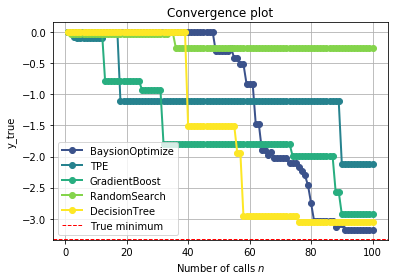

In [19]:
plt.show(plot_results(*methods, true_minimum=benchmarks[setting['benchmark']]['y'], 
                      max_n_calls=100, choice='y_true'))

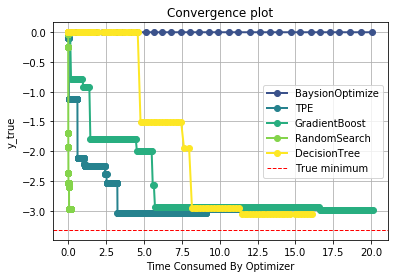

In [39]:
plt.show(plot_results(*methods, true_minimum=benchmarks[setting['benchmark']]['y'], 
                      choice='y_true', x_mark='time', target_time=0, max_time=20))

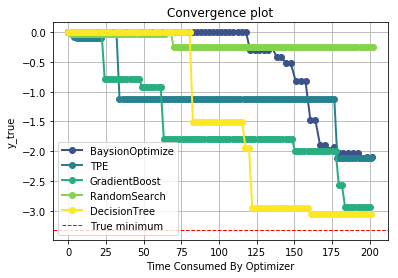

In [40]:
plt.show(plot_results(*methods, true_minimum=benchmarks[setting['benchmark']]['y'], 
                      choice='y_true', x_mark='time', target_time=2, max_time=200))

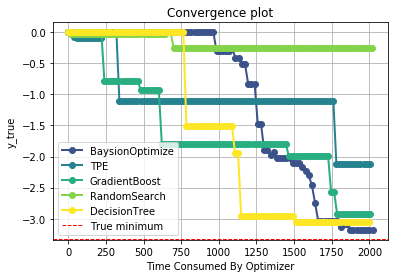

In [41]:
plt.show(plot_results(*methods, true_minimum=benchmarks[setting['benchmark']]['y'], 
                      choice='y_true', x_mark='time', target_time=20, max_time=2000))

In [ ]:
plt.show(plot_results(*methods, true_minimum=benchmarks[setting['benchmark']]['y'], 
                      max_n_calls=100, choice='y_output'))

Afllunce By:
    - error of model
    - required time for each training
    - method of cross validation
    - number of parameters 
    - type of parameters

In [ ]:
Table For Each Optimizer
Time Comsumed By Optimizer | Calls Of Target | Best Score | True Best Score | Error Of x

Help on Figure in module matplotlib.figure object:

class Figure(matplotlib.artist.Artist)
 |  The Figure instance supports callbacks through a *callbacks*
 |  attribute which is a :class:`matplotlib.cbook.CallbackRegistry`
 |  instance.  The events you can connect to are 'dpi_changed', and
 |  the callback will be called with ``func(fig)`` where fig is the
 |  :class:`Figure` instance.
 |  
 |  *patch*
 |     The figure patch is drawn by a
 |     :class:`matplotlib.patches.Rectangle` instance
 |  
 |  *suppressComposite*
 |     For multiple figure images, the figure will make composite
 |     images depending on the renderer option_image_nocomposite
 |     function.  If suppressComposite is True|False, this will
 |     override the renderer.
 |  
 |  Method resolution order:
 |      Figure
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, figsize=None, dpi=None, facecolor=None, edgecolor=None, li

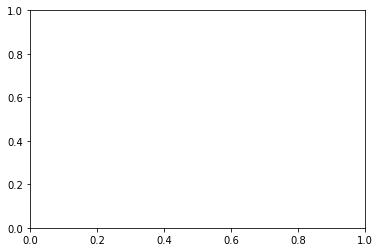

In [9]:
ax = plt.gcf()
help(ax)
ax

In [3]:
F = plt.figure(figsize=(800, 800))
ax = plt.gca()
F.add_axes(ax)

In [ ]:
plt.show()